# Project: Data Analysis of a dataset from The Movie Database (TMDB)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this report, we will analyse a dataset obtained from The Movie Database (TMDB). The dataset contains information about 10,000 movies; this information includes numerical data such as budget, revenue, and user ratings, as well as non-numerical data such as director, cast, and genre. 

We will investigate the most popular directors, production companies, and genres. We will also investigate which properties are associated with movies revenue.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms;
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In this section, we load the data, inspect it for cleanliness & trim and clean the dataset. Trimming and cleaning will be performed _alongside_ inspection (and not at the end of the section).

We begin by loading the data and inspecting it.

In [2]:
df = pd.read_csv('tmdb-movies.csv')
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


The final two columns ending with _adj show the budget and revenue of the associated movie
in terms of 2010 dollars to account for inflation over time. Let us rename these so that there is no confusion later.

We will be working with these throughout: **So, from this point on by "revenue" and "budget" we will always mean "adjusted revenue" and "adjusted budget".**

Let's also divide by 1,000,000 so that our base unit is millions of dollars.

In [3]:
df.rename(columns = {"budget_adj":"adjusted_budget", "revenue_adj":"adjusted_revenue"}, inplace = True)
df.adjusted_budget = df.adjusted_budget/1e6
df.adjusted_revenue = df.adjusted_revenue/1e6

Let us now look at some summary data for the whole pandas DataFrame.

In [4]:
print (df.shape)
print (df.info())

(10866, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release

In [5]:
print( "The number of null values is:", df.isnull().any(axis=1).sum()) 

The number of null values is: 8874


We see that, although there are 10866 rows, the following columns have empty rows: imdb_id, cast, homepage, director, tagline, keywords, overview, genres, production_companies. Note that these are all non-numerical and, all excepting "genres", will not feature in our analysis. So all of these columns, except for "genres", can be dropped. 

In [6]:
df_original = df.copy() # Make a copy of the original, in case we need it later 
df = df_original[['adjusted_budget', 'adjusted_revenue', 'original_title', 'popularity', 'runtime', 'vote_count', 'vote_average', 'release_year', 'genres']]

In [7]:
print( "The number of null values is now:", df.isnull().any(axis=1).sum()) 

The number of null values is now: 23


In [8]:
df['genres'].isnull().sum()

23

Clearly, all the remaining null values are in the genres column. Since there are relatively few of these, let us simply remove the rows containing these:

In [9]:
df = df[~df['genres'].isnull()]

In [10]:
print( "The number of null values is now:", df.isnull().any(axis=1).sum())

The number of null values is now: 0


We now check for and remove duplicates in the data

In [11]:
print( "The number of duplicated rows is:", sum(df.duplicated()) )
df[df.duplicated()]

The number of duplicated rows is: 1


,adjusted_budget,adjusted_revenue,original_title,popularity,runtime,vote_count,vote_average,release_year,genres
2090,30.0,0.967,TEKKEN,0.59643,92,110,5.0,2010,Crime|Drama|Action|Thriller|Science Fiction


Let's double check that this really is duplicated, using the title of the movie as our "KEY":

In [12]:
df[df.original_title == "TEKKEN"]

,adjusted_budget,adjusted_revenue,original_title,popularity,runtime,vote_count,vote_average,release_year,genres
2089,30.0,0.967,TEKKEN,0.59643,92,110,5.0,2010,Crime|Drama|Action|Thriller|Science Fiction
2090,30.0,0.967,TEKKEN,0.59643,92,110,5.0,2010,Crime|Drama|Action|Thriller|Science Fiction


Yes, it is. So it can be safely removed. 

In [13]:
df = df.drop_duplicates()# .reset_index(drop=True)
print( "The number of duplicated rows is now:", sum(df.duplicated()) )

The number of duplicated rows is now: 0


Lastly, we set the 'adjusted_budget' and 'adjusted_revenue' column to be integers. (If we were intending to use "release_date" we would want to set this to the datetime datatype.)

In [14]:
df = df.astype({'adjusted_budget': 'int64', 'adjusted_revenue': 'int64'})
df.head(1)

,adjusted_budget,adjusted_revenue,original_title,popularity,runtime,vote_count,vote_average,release_year,genres
0,137,1392,Jurassic World,32.985763,124,5562,6.5,2015,Action|Adventure|Science Fiction|Thriller


We can now look at the summary data for the trimmed dataframe to check that there is no more cleaning to do.

In [15]:
df.describe()

,adjusted_budget,adjusted_revenue,popularity,runtime,vote_count,vote_average,release_year
count,10842.000000,10842.000000,10842.000000,10842.000000,10842.000000,10842.000000,10842.000000
mean,17.365523,51.268954,0.647461,102.138443,217.823649,5.974064,2001.314794
std,34.203508,144.669094,1.001032,31.294612,576.180993,0.934257,12.813617
min,0.000000,0.000000,0.000065,0.000000,10.000000,1.500000,1960.000000
25%,0.000000,0.000000,0.208210,90.000000,17.000000,5.400000,1995.000000
50%,0.000000,0.000000,0.384532,99.000000,38.000000,6.000000,2006.000000
75%,20.000000,33.000000,0.715393,111.000000,146.000000,6.600000,2011.000000
max,425.000000,2827.000000,32.985763,900.000000,9767.000000,9.200000,2015.000000


Although there are details for 10842 movies, there seems to be movies that have a budget and/or revenue of 0 dollars. This is clearly a case of these details not being recorded for these movies.

In [16]:
print(sum(df.adjusted_budget == 0))

6000


Six thousand movies have no recorded budget. We could replace these zeroes with the mean value, but because 6000 is such a large proportion of the total (55% of 10842), doing so will have a distorting effect on the analysis. I will be removing these movies from the numerical analysis (but keeping them in the non-numerical analysis.)

In [17]:
print(sum(df.adjusted_budget == 0))
df2 = df[~(df.adjusted_budget == 0)]
print(sum(df2.adjusted_budget == 0))

6000
0


We also need to remove movies with no recorded revenue.

In [18]:
print(sum(df2.adjusted_revenue == 0))
df3 = df2[~(df2.adjusted_revenue == 0)]
print(sum(df3.adjusted_revenue == 0))

1293
0


1293 further movies were removed.

In [19]:
df = df3 

`df` will be used for the numerical analysis. 
`df_original` will be used for the non-numerical analysis.

<a id='eda'></a>
## Exploratory Data Analysis

We can now look at the summary data for the trimmed dataframe.                                                

In [20]:
df.describe()

,adjusted_budget,adjusted_revenue,popularity,runtime,vote_count,vote_average,release_year
count,3549.000000,3549.000000,3549.000000,3549.000000,3549.000000,3549.000000,3549.000000
mean,46.974923,147.798535,1.253185,110.025641,564.905044,6.188053,2000.906453
std,45.141394,221.480420,1.519041,19.605140,906.718106,0.785324,11.415724
min,1.000000,1.000000,0.010335,26.000000,10.000000,3.300000,1960.000000
25%,16.000000,25.000000,0.496059,96.000000,82.000000,5.700000,1995.000000
50%,32.000000,71.000000,0.869474,106.000000,231.000000,6.200000,2004.000000
75%,64.000000,176.000000,1.454579,120.000000,622.000000,6.700000,2010.000000
max,425.000000,2827.000000,32.985763,248.000000,9767.000000,8.400000,2015.000000


There is a lot of useful summary detail here that give us an overview of our dataframe, e.g., we are looking at movies released between 1960 and 2015, with budgets up to 425,000,000 million dollars; the mean runtime is 110 minutes; most films were released in 2015.

We can also do a quick overview with a scatter matrix.

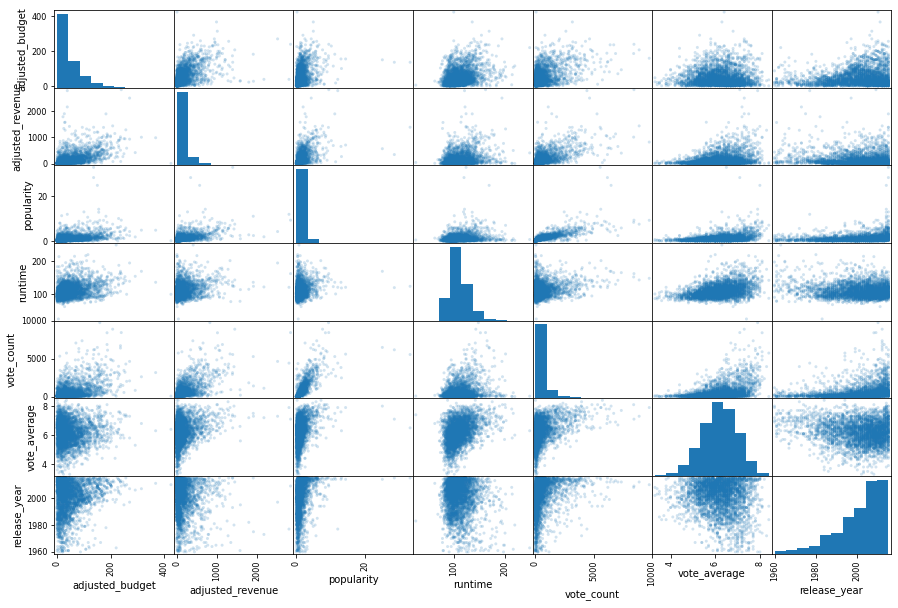

In [21]:
pd.plotting.scatter_matrix(df, figsize = (15,10), alpha=0.2);

On inspection, the histogram for average votes shows a normal distribution. This is as expected as most movies won't be rated as either very poor or very good. The release year histogram is left-skewed, indicating that the number of movies being released increases each year, with the most being released in the final recorded year in the dataset (which we discovered earlier is 2015.)

The revenue appears to be correlated with budget, popularity, and average votes. We will look at these more closely later in this section.

### Who are the most prolific directors?

In [22]:
print(df_original.director.value_counts()[0:10])

Woody Allen          45
Clint Eastwood       34
Steven Spielberg     29
Martin Scorsese      29
Ridley Scott         23
Ron Howard           22
Steven Soderbergh    22
Joel Schumacher      21
Brian De Palma       20
Barry Levinson       19
Name: director, dtype: int64


Above, we see the top 10 most prolific directors (between 2006 and 2015), with Woody Allen directing a total of 45 movies.

### Which production companies produce the most movies?

In [23]:
print(df_original.production_companies.value_counts()[0:10])

Paramount Pictures                        156
Universal Pictures                        133
Warner Bros.                               84
Walt Disney Pictures                       76
Columbia Pictures                          72
Metro-Goldwyn-Mayer (MGM)                  72
New Line Cinema                            61
Touchstone Pictures                        51
20th Century Fox                           50
Twentieth Century Fox Film Corporation     49
Name: production_companies, dtype: int64


Above, we see the top 10 production companies (between 2006 and 2015), with Paramount Pictures producing a total of 156 movies.

### What are the most popular genres?

Let us look at the unique genres listed in the dataframe:

In [24]:
df['genres'].unique()

array(['Action|Adventure|Science Fiction|Thriller',
       'Adventure|Science Fiction|Thriller',
       'Action|Adventure|Science Fiction|Fantasy', ...,
       'Action|Drama|Horror|Thriller', 'Adventure|Animation|Drama',
       'Action|Adventure|Drama|War|Romance'], dtype=object)

This is confusing because each movie has multiple associated genres. Let us unpack these genres and then count how many times each individual genre appears in the dataframe.

In [25]:
genre_df = pd.DataFrame(df_original['genres'].str.split("|").explode()) # Please see the appendix for notes on this code

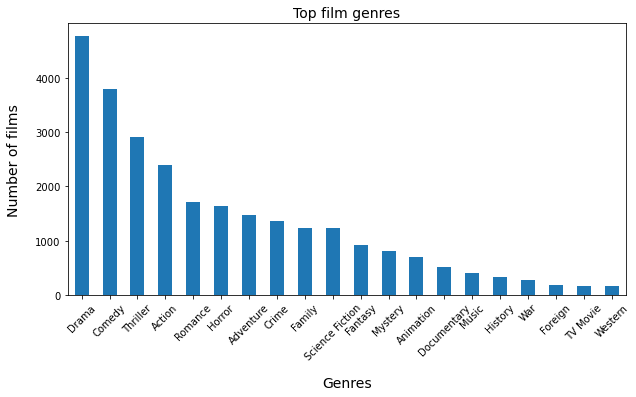

In [26]:
genre_df['genres'].value_counts().plot(kind='bar', figsize = (10,5));
genre_df['genres'].value_counts().plot(kind='bar', figsize = (10,5));
plt.xticks(rotation = 45);
plt.xlabel("Genres", labelpad=14, fontsize = 14);
plt.ylabel("Number of films", labelpad=14, fontsize = 14);
plt.title("Top film genres", fontsize = 14);
plt.savefig('top-film-genres.PNG')

We see that the most common genre is "Drama" and the least common genre is "Western".

### Which variables correlate with revenue?

We will plot the following independent variables against the independent variable, "revenue": "popularity", "budget", and "average vote". We will make use of the linear regression model fit afforded by seaborn's regplot function to perform a visual inspection.

In [27]:
 def regression_plot(x, y, data = df, xlabel = "", ylabel = "", title = "", xlim = (0,10), ylim = (0,1000)):
    '''This function is used to plot the dependent variable against the independent variable.'''       
    plt.figure(figsize = (10,10))
    ax = sns.regplot(x=x, y=y, data=df, marker="+", scatter_kws={'alpha':0.3})
    plt.xlabel(xlabel, labelpad=14, fontsize = 14);
    plt.ylabel(ylabel, labelpad=14, fontsize = 14);
    plt.title(title, fontsize = 14);
    plt.xlim(xlim[0],xlim[1]); plt.ylim(ylim[0],ylim[1]);

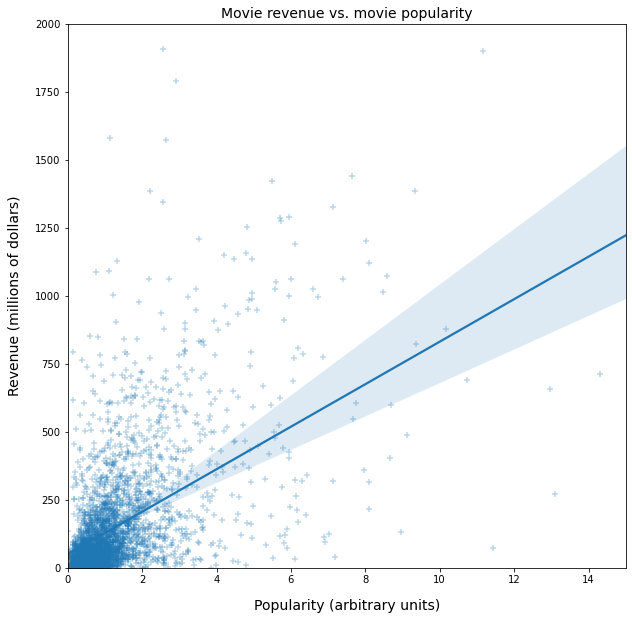

In [28]:
regression_plot(x="popularity", y="adjusted_revenue", xlabel = 'Popularity (arbitrary units)', ylabel = 'Revenue (millions of dollars)', title = "Movie revenue vs. movie popularity", xlim = (0,15), ylim = (0,2000))
plt.savefig('revenue_vs_popularity.PNG')

A movie's revenue is positively correlated with the popularity of the movie, as expected. The diverging confidence intervals are possibly due to the data being sparses at higher values.

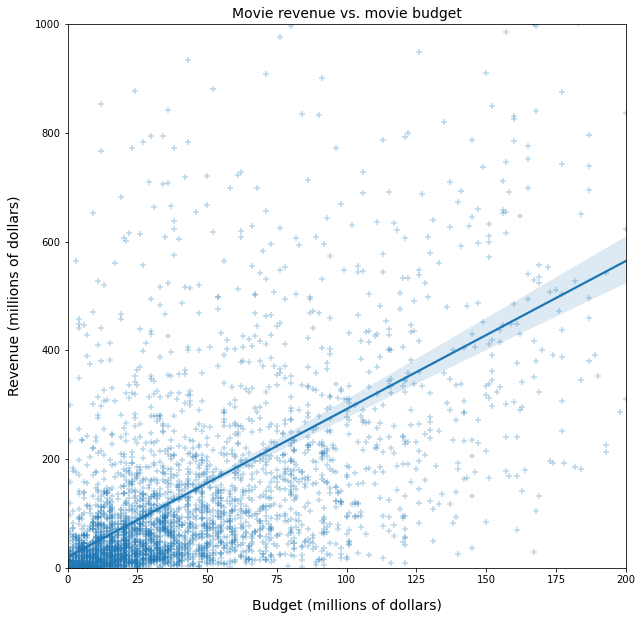

In [29]:
regression_plot(x="adjusted_budget", y="adjusted_revenue", xlabel = 'Budget (millions of dollars)', ylabel = 'Revenue (millions of dollars)', title = "Movie revenue vs. movie budget", xlim = (0,200), ylim = (0,1000))
plt.savefig('revenue_vs_budget.PNG')

A movie's revenue is positively correlated with the budget of the movie. The diverging confidence intervals are again possibly due to the data being sparses at higher values, though less so than in the previous plot.

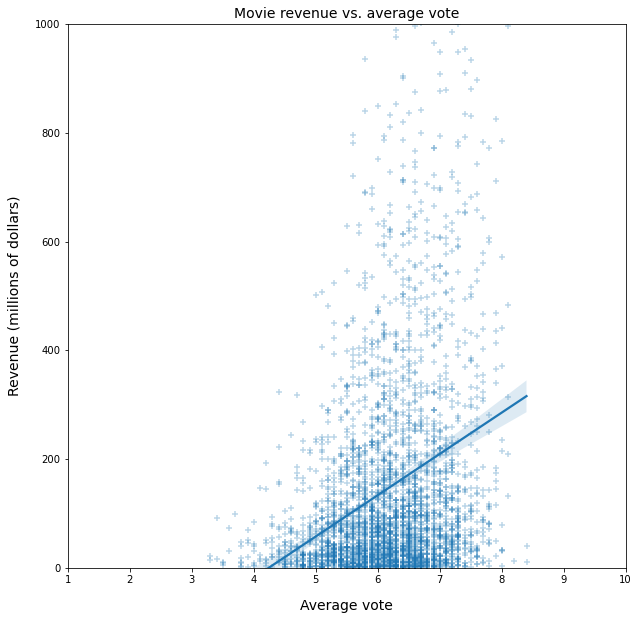

In [30]:
regression_plot(x="vote_average", y="adjusted_revenue", data=df, xlabel='Average vote', ylabel = 'Revenue (millions of dollars)', title = "Movie revenue vs. average vote", xlim = (1,10), ylim = (0,1000))

Whilst movie revenue does seem to be positively correlated with the average vote, the correlation appears to be weak. Let us calculate the R$^2$ (R-squared) value to check. R$^2$ is a statistical measure of fit: in short, +1 is perfect positive correlation and -1 is perfect negative correlation.

In [31]:
df['intercept'] = 1
lm = sms.OLS(df['vote_average'], df[['intercept', 'adjusted_revenue']])
results = lm.fit(); results.summary()

<ipython-input-31-2a3e0158c838>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['intercept'] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     277.5
Date:                Wed, 19 Jan 2022   Prob (F-statistic):           4.75e-60
Time:                        19:12:13   Log-Likelihood:                -4044.0
No. Observations:                3549   AIC:                             8092.
Df Residuals:                    3547   BIC:                             8104.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            6.0469      0.015    396.124      0.000       6.017       6.077
adjusted_revenue     0.0010   5.73e-05     16.659      0.000       0.001       0.001
==============================================================================
Omnibus:                       29.562   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.075
Skew:                          -0.222   Prob(JB):                     2.95e-07
Kurtosis:                       3.078   Cond. No.                         320.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R$^2$ value is only 0.073; this is close to zero and so the correlation is very weak indeed.

<a id='conclusions'></a>
## Conclusions

We analysed the TMDB database for movies released between 1960 and 2015.

The most prolific director is Woody Allen, and the production company that has produced the most movies is Paramount Pictures.
The most common genre is "Drama", and the least common genre is "Western".

For our numerical analysis, we removed those movies which had no recorded budget or revenue. 

On visual inspection, the following two variables appear to be positively correlated with increased revenue: Popularity & Budget. Both visual inspection and an R$^2$ value close to zero indicate only a very weak correlation of the revenue with average vote. We may need to clean up the data a little more and pay more attention to error margins to draw a definitive conclusion.

#### Appendix

In order to unpack the list, we used the Pandas vectorized operation :
    
    pd.DataFrame(df['genres'].str.split("|").explode())
    
Here, series.str.split() was used to create a list from a string.
Then, df.explode() was used to unpack the list.

A pythonic solution is also possible, but it is more involved:  

    all_genres = [str(text).split("|") for text in df['genres']]  # Creates a list of lists, which isn't quite what we want
    flat_list = [item for sublist in all_genres for item in sublist  ] # unpack the list of lists
    genre_df = pd.DataFrame(flat_list, columns = {'genres'})